In [25]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 3 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


# Beta random selection (K=3, T=4)

48 11 11 10 20


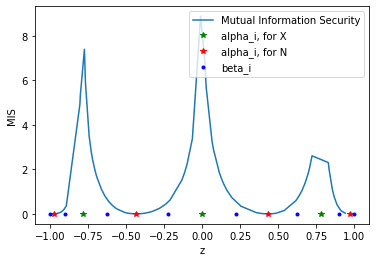

[ 7.81831482e-01  6.12323400e-17 -7.81831482e-01]
[ 0.97492791  0.43388374 -0.43388374 -0.97492791]
[ 9.74927912e-01  7.81831482e-01  4.33883739e-01  6.12323400e-17
 -4.33883739e-01 -7.81831482e-01 -9.74927912e-01]


In [6]:
K = 3
T = 4
Noise_Alloc = [0,2,4,6]
sigma = 2

N = 8

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 100
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    

print(alpha_array[Signal_Alloc])
print(alpha_array[Noise_Alloc])
print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [7]:
sigma = 1

z_array_sel = z_array_0
X_tilde_s0,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_1
X_tilde_s1,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_2
X_tilde_s2,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_3
X_tilde_s3,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

z_array_sel = z_array_4
X_tilde_s4,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)

@BACC_Enc: N,K,T, m_i= 48 3 4 20000 

@BACC_Enc: N,K,T, m_i= 11 3 4 20000 

@BACC_Enc: N,K,T, m_i= 11 3 4 20000 

@BACC_Enc: N,K,T, m_i= 10 3 4 20000 

@BACC_Enc: N,K,T, m_i= 20 3 4 20000 



<Figure size 432x288 with 0 Axes>

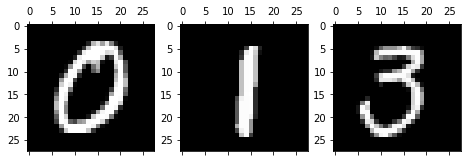

In [8]:
index_num = 3

index_sel = np.array(range(K))*Size_submatrices + index_num

input_images = encoding_input_array_np[index_sel,:]
input_labels = encoding_label_array_np[index_sel,:]

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,K):
    ax = fig.add_subplot(1,6,i+1)
    pixels = input_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

Encoded images B<0.5


<Figure size 432x288 with 0 Axes>

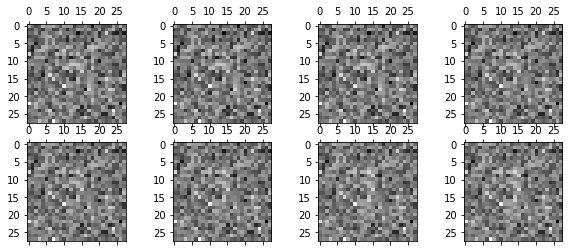

Encoded images 0.5<B<1


<Figure size 432x288 with 0 Axes>

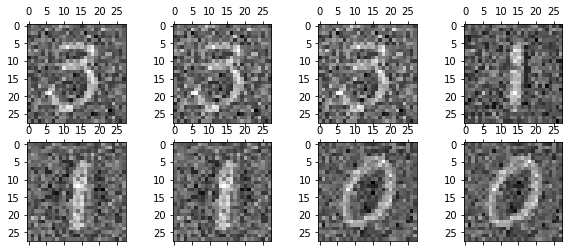

Encoded images 1<B<1.5


<Figure size 432x288 with 0 Axes>

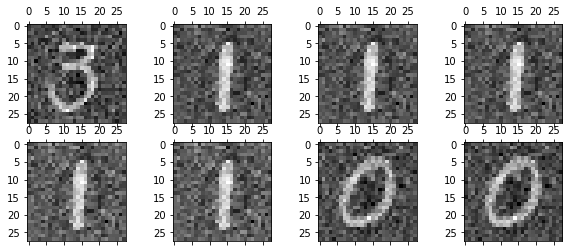

In [9]:


print("Encoded images B<0.5")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s0[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i+12,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images 0.5<B<1")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s1[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images 1<B<1.5")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s2[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()



Encoded images 1.5<B<2


<Figure size 432x288 with 0 Axes>

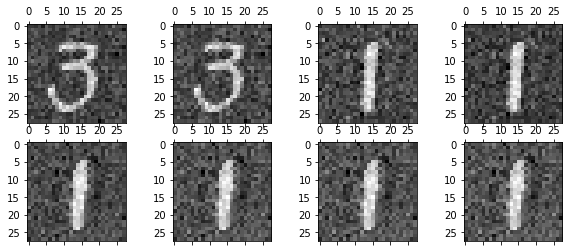

Encoded images B>2


<Figure size 432x288 with 0 Axes>

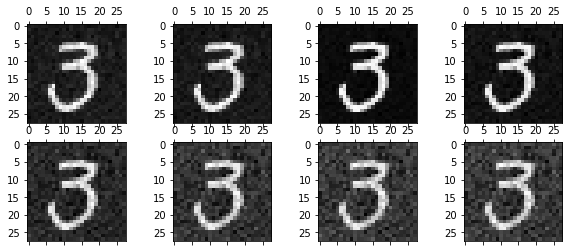

In [10]:
print("Encoded images 1.5<B<2")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s3[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

print("Encoded images B>2")
# print(X_tilde.shape)
# print(y_tilde.shape)
# print(encoded_images.shape)
np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s4[:,index_num,:]
for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [2]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 3
T = 4
sigma = 1
Noise_Alloc = [0,2,4,6]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [3,4,5,6,7,8]
B_array = [0.5, 1, 2]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
        while(len(z_array)<N):
            z_tmp = np.random.uniform(-1,1,1)
            MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
            if MIS_tmp < B and MIS_tmp > 0.1:
                z_array.append(z_tmp[0])
        
        z_array = np.sort(z_array)
        print('z_array:',z_array)
        
        sigma = 1 #sigma_array[sigma_idx]
        
        _Noise_label = np.ones((20000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.00, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.31846728  0.35946123  0.51428799]
@BACC_Enc: N,K,T, m_i= 3 3 4 20000 

@BACC_Enc: N,K,T, m_i= 3 3 4 20000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [0 1 2]

Test set: Average loss: 1.9650 
Accuracy: 6990/10000 (69.90%)

Round   0, Average loss 1.965 Test accuracy 69.900
selected users: [0 1 2]

Test set: Average loss: 1.8748 
Accuracy: 6375/10000 (63.75%)

Round   1, Average loss 1.875 Test accuracy 63.750
selected users: [0 1 2]

Test set: Average loss: 1.9600 
Accuracy: 4715/10000 (47.15%)

Round   2, Average loss 1.960 Test accuracy 47.150
selected users: [0 1 2]

Test set: Average loss: 1.2501 
Accuracy: 7672/10000 (76.72%)

Round   3, Average loss 1.250 Test accuracy 76.720
selected users: [0 1 2]

Test set: Average loss: 1.2192 
Accuracy: 7844/10000 (78.44%)

Round   4, Average loss 1.219 Test accuracy 78.440
selected users: [0 1 2]

Test set: Average loss: 1.7091 
Accuracy: 7444/10000 (74.44%)

Round   5, Average loss 1.709 Test accuracy 74.440
selected use


Test set: Average loss: 1.2117 
Accuracy: 7754/10000 (77.54%)

Round  27, Average loss 1.212 Test accuracy 77.540
selected users: [0 1 2]

Test set: Average loss: 1.1171 
Accuracy: 8314/10000 (83.14%)

Round  28, Average loss 1.117 Test accuracy 83.140
selected users: [0 1 2]

Test set: Average loss: 0.9539 
Accuracy: 8467/10000 (84.67%)

Round  29, Average loss 0.954 Test accuracy 84.670
z_array: [-0.63388104  0.30799259  0.35277372]
@BACC_Enc: N,K,T, m_i= 3 3 4 20000 

@BACC_Enc: N,K,T, m_i= 3 3 4 20000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [0 1 2]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2]

Test set: Average loss: 0.4185 
Accuracy: 9409/10000 (94.09%)

Round   1, Average loss 0.419 Test accuracy 94.090
selected users: [0 1 2]

Test set: Average loss: 0.6543 
Accuracy: 9368/10000 (93.68%)

Round   2, Average loss 0.654 Test accuracy 93.680
selected users: [0 1 2]

Test set: Aver


Test set: Average loss: 0.5224 
Accuracy: 9189/10000 (91.89%)

Round  24, Average loss 0.522 Test accuracy 91.890
selected users: [0 1 2 3]

Test set: Average loss: 1.2008 
Accuracy: 9148/10000 (91.48%)

Round  25, Average loss 1.201 Test accuracy 91.480
selected users: [0 1 2 3]

Test set: Average loss: 1.1033 
Accuracy: 8168/10000 (81.68%)

Round  26, Average loss 1.103 Test accuracy 81.680
selected users: [0 1 2 3]

Test set: Average loss: 1.2246 
Accuracy: 7791/10000 (77.91%)

Round  27, Average loss 1.225 Test accuracy 77.910
selected users: [0 1 2 3]

Test set: Average loss: 1.1379 
Accuracy: 9075/10000 (90.75%)

Round  28, Average loss 1.138 Test accuracy 90.750
selected users: [0 1 2 3]

Test set: Average loss: 1.1578 
Accuracy: 7730/10000 (77.30%)

Round  29, Average loss 1.158 Test accuracy 77.300
z_array: [-0.28011584  0.58191899  0.59556242  0.90248964]
@BACC_Enc: N,K,T, m_i= 4 3 4 20000 

@BACC_Enc: N,K,T, m_i= 4 3 4 20000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users


Test set: Average loss: 1.0224 
Accuracy: 9484/10000 (94.84%)

Round  20, Average loss 1.022 Test accuracy 94.840
selected users: [0 1 2 3]

Test set: Average loss: 0.9849 
Accuracy: 9439/10000 (94.39%)

Round  21, Average loss 0.985 Test accuracy 94.390
selected users: [0 1 2 3]

Test set: Average loss: 1.1482 
Accuracy: 8186/10000 (81.86%)

Round  22, Average loss 1.148 Test accuracy 81.860
selected users: [0 1 2 3]

Test set: Average loss: 1.0367 
Accuracy: 9468/10000 (94.68%)

Round  23, Average loss 1.037 Test accuracy 94.680
selected users: [0 1 2 3]

Test set: Average loss: 1.0325 
Accuracy: 9422/10000 (94.22%)

Round  24, Average loss 1.032 Test accuracy 94.220
selected users: [0 1 2 3]

Test set: Average loss: 1.0248 
Accuracy: 9383/10000 (93.83%)

Round  25, Average loss 1.025 Test accuracy 93.830
selected users: [0 1 2 3]

Test set: Average loss: 1.0234 
Accuracy: 9408/10000 (94.08%)

Round  26, Average loss 1.023 Test accuracy 94.080
selected users: [0 1 2 3]

Test set: Av


Test set: Average loss: 2.0156 
Accuracy: 9301/10000 (93.01%)

Round  15, Average loss 2.016 Test accuracy 93.010
selected users: [0 1 2 3 4]

Test set: Average loss: 2.0726 
Accuracy: 9063/10000 (90.63%)

Round  16, Average loss 2.073 Test accuracy 90.630
selected users: [0 1 2 3 4]

Test set: Average loss: 1.9497 
Accuracy: 9349/10000 (93.49%)

Round  17, Average loss 1.950 Test accuracy 93.490
selected users: [0 1 2 3 4]

Test set: Average loss: 1.9641 
Accuracy: 9113/10000 (91.13%)

Round  18, Average loss 1.964 Test accuracy 91.130
selected users: [0 1 2 3 4]

Test set: Average loss: 1.9638 
Accuracy: 9201/10000 (92.01%)

Round  19, Average loss 1.964 Test accuracy 92.010
selected users: [0 1 2 3 4]

Test set: Average loss: 1.9056 
Accuracy: 9357/10000 (93.57%)

Round  20, Average loss 1.906 Test accuracy 93.570
selected users: [0 1 2 3 4]

Test set: Average loss: 1.9302 
Accuracy: 9314/10000 (93.14%)

Round  21, Average loss 1.930 Test accuracy 93.140
selected users: [0 1 2 3 4]


Test set: Average loss: 2.1001 
Accuracy: 6664/10000 (66.64%)

Round  10, Average loss 2.100 Test accuracy 66.640
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0059 
Accuracy: 7901/10000 (79.01%)

Round  11, Average loss 2.006 Test accuracy 79.010
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0147 
Accuracy: 6753/10000 (67.53%)

Round  12, Average loss 2.015 Test accuracy 67.530
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0796 
Accuracy: 6612/10000 (66.12%)

Round  13, Average loss 2.080 Test accuracy 66.120
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0192 
Accuracy: 8352/10000 (83.52%)

Round  14, Average loss 2.019 Test accuracy 83.520
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0805 
Accuracy: 5390/10000 (53.90%)

Round  15, Average loss 2.080 Test accuracy 53.900
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.0285 
Accuracy: 7223/10000 (72.23%)

Round  16, Average loss 2.029 Test accuracy 72.230
selected users:


Test set: Average loss: 1.4521 
Accuracy: 7567/10000 (75.67%)

Round   4, Average loss 1.452 Test accuracy 75.670
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.2416 
Accuracy: 8609/10000 (86.09%)

Round   5, Average loss 1.242 Test accuracy 86.090
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.0045 
Accuracy: 8705/10000 (87.05%)

Round   6, Average loss 1.005 Test accuracy 87.050
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.5262 
Accuracy: 8776/10000 (87.76%)

Round   7, Average loss 1.526 Test accuracy 87.760
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.3312 
Accuracy: 8201/10000 (82.01%)

Round   8, Average loss 1.331 Test accuracy 82.010
selected users: [0 1 2 3 4 5]

Test set: Average loss: 0.9524 
Accuracy: 8611/10000 (86.11%)

Round   9, Average loss 0.952 Test accuracy 86.110
selected users: [0 1 2 3 4 5]

Test set: Average loss: 1.8160 
Accuracy: 4973/10000 (49.73%)

Round  10, Average loss 1.816 Test accuracy 49.730
selected users:


Test set: Average loss: 2.1110 
Accuracy: 4021/10000 (40.21%)

Round  29, Average loss 2.111 Test accuracy 40.210
z_array: [-0.5381116  -0.30131538 -0.28114992 -0.2208316   0.26359422  0.3510913
  0.91775268]
@BACC_Enc: N,K,T, m_i= 7 3 4 20000 

@BACC_Enc: N,K,T, m_i= 7 3 4 20000 

(T, sigma)= 4 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2790 
Accuracy: 3956/10000 (39.56%)

Round   1, Average loss 2.279 Test accuracy 39.560
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2423 
Accuracy: 5635/10000 (56.35%)

Round   2, Average loss 2.242 Test accuracy 56.350
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.0941 
Accuracy: 8009/10000 (80.09%)

Round   3, Average loss 2.094 Test accuracy 80.090
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.0204 
Accuracy: 9128/10000 (91.28%)

Ro


Test set: Average loss: 2.2566 
Accuracy: 3616/10000 (36.16%)

Round  23, Average loss 2.257 Test accuracy 36.160
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2570 
Accuracy: 3264/10000 (32.64%)

Round  24, Average loss 2.257 Test accuracy 32.640
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2507 
Accuracy: 6332/10000 (63.32%)

Round  25, Average loss 2.251 Test accuracy 63.320
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.1775 
Accuracy: 7159/10000 (71.59%)

Round  26, Average loss 2.178 Test accuracy 71.590
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.1892 
Accuracy: 8546/10000 (85.46%)

Round  27, Average loss 2.189 Test accuracy 85.460
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2662 
Accuracy: 1067/10000 (10.67%)

Round  28, Average loss 2.266 Test accuracy 10.670
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 2.2571 
Accuracy: 6935/10000 (69.35%)

Round  29, Average loss 2.257 Test accuracy 69.350
z_a


Test set: Average loss: 2.0283 
Accuracy: 8620/10000 (86.20%)

Round  16, Average loss 2.028 Test accuracy 86.200
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8984 
Accuracy: 8669/10000 (86.69%)

Round  17, Average loss 1.898 Test accuracy 86.690
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0716 
Accuracy: 9208/10000 (92.08%)

Round  18, Average loss 2.072 Test accuracy 92.080
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0826 
Accuracy: 7730/10000 (77.30%)

Round  19, Average loss 2.083 Test accuracy 77.300
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0132 
Accuracy: 7798/10000 (77.98%)

Round  20, Average loss 2.013 Test accuracy 77.980
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0627 
Accuracy: 6793/10000 (67.93%)

Round  21, Average loss 2.063 Test accuracy 67.930
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.9792 
Accuracy: 8513/10000 (85.13%)

Round  22, Average loss 1.979 Test accurac

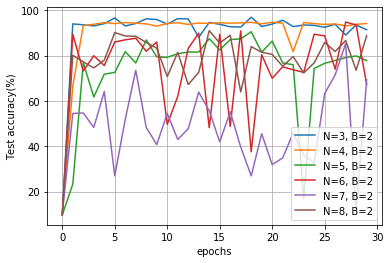

In [7]:
N_array = [3,4,5,6,7,8]
B_array = [0.5, 1, 2]

B_sel = 2

plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=3, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=5, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

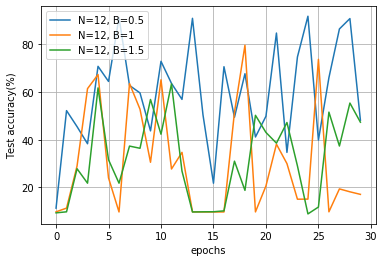

In [72]:
plt.plot(acc_test_arr_v1[1,0,0,0:30],label='N=12, B=0.5')
plt.plot(acc_test_arr_v1[1,1,0,0:30],label='N=12, B=1')
plt.plot(acc_test_arr_v1[1,2,0,0:30],label='N=12, B=1.5')
# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# K=2, T=3

In [8]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 2 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


257 62 36 35 110


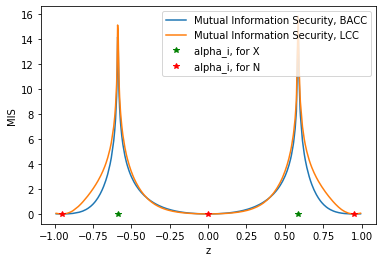

-0.9897250636443959 0.00707871966985843
-0.989639633899249 0.007050463780960947
-0.9875199231535203 0.00636374264307918
-0.9838096632741091 0.0052305893951158965
-0.9752846611530523 0.0029878556256992283
-0.9613385487353221 0.0005780885978518346
-0.9609328545526186 0.0005344956924667337
-0.9585384518302251 0.00031059737225043585
-0.9571400750758072 0.00020685164483735178
-0.9528751159784254 1.8903486303407864e-05
-0.9523230467455044 9.195229765585917e-06
-0.9502364449878749 3.897810722932505e-06
-0.9482985844858938 4.453936438222673e-05
-0.9380998435368537 0.0010381575708618353
-0.9232229121023656 0.005196124323258639
-0.9202153814993796 0.006486799138169889
-0.9132471725816904 0.010135522510636407
-0.9116812893608466 0.011089488556447672
-0.9116783034359333 0.011091356637117748
-0.9114423228753692 0.011239587980341467
-0.9111669073878768 0.011414080545420575
-0.9094782369927537 0.012519430648184362
-0.9081789957751656 0.01341206717490203
-0.9058299755352051 0.015121574600616363
-0.905

In [125]:
K = 2
T = 3
Noise_Alloc = [0,2,4]
sigma = 2

N = 6

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 500
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [74]:
z_array = np.array([-0.81, -0.22, 0.21, 0.82])

print('z_array:',z_array)
for j in range(len(z_array)):
    print([z_array[j]],MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

z_array: [-0.81 -0.22  0.21  0.82]
[-0.81] 0.4838626198316927
[-0.22] 0.46852880899669475
[0.21] 0.4220940221610922
[0.82] 0.3976313011563456


In [61]:
print(sigma)

1


In [79]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,6,8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

        if N==2:
            z_array = np.array([-0.81, 0.81])
        elif N ==4:
            z_array = np.array([-0.81, -0.22, 0.22, 0.81])
        elif N ==5:
            z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
        elif N ==6:
            z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
        elif N ==7:
            z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
        else:
            z_array = np.array([-0.9, -0.81, -0.22, -0.16, 0.16, 0.22, 0.81, 0.9])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.2364 
Accuracy: 2108/10000 (21.08%)

Round   0, Average loss 2.236 Test accuracy 21.080
selected users: [0 1]

Test set: Average loss: 1.4988 
Accuracy: 7467/10000 (74.67%)

Round   1, Average loss 1.499 Test accuracy 74.670
selected users: [0 1]

Test set: Average loss: 0.1856 
Accuracy: 9755/10000 (97.55%)

Round   2, Average loss 0.186 Test accuracy 97.550
selected users: [0 1]

Test set: Average loss: 0.1907 
Accuracy: 9762/10000 (97.62%)

Round   3, Average loss 0.191 Test accuracy 97.620
selected users: [0 1]

Test set: Average loss: 0.1902 
Accuracy: 9765/10000 (97.65%)

Round   4, Average loss 0.190 Test accuracy 97.650
selected users: [0 1]

Test set: Average loss: 0.2301 
Accuracy: 9757/10000 (97.57%)

Round   5, Average loss 0.230 Test accuracy 97.570
selected 


Test set: Average loss: 1.8423 
Accuracy: 9667/10000 (96.67%)

Round  27, Average loss 1.842 Test accuracy 96.670
selected users: [0 1 2 3]

Test set: Average loss: 1.9721 
Accuracy: 9667/10000 (96.67%)

Round  28, Average loss 1.972 Test accuracy 96.670
selected users: [0 1 2 3]

Test set: Average loss: 1.9144 
Accuracy: 8882/10000 (88.82%)

Round  29, Average loss 1.914 Test accuracy 88.820
z_array: [-0.9  -0.81 -0.22  0.22  0.81  0.9 ]
0.039572349708934106
0.4838626198316927
0.46852880899669475
0.468528808996694
0.48386261983169315
0.039572349708934106
@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.2521 
Accuracy: 3024/10000 (30.24%)

Round   0, Average loss 2.252 Test accuracy 30.240
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.1985 
Accuracy: 5895/10000 (58.95%)

Round   1, Average loss 2.198 Test accuracy 58.950
selected users: [0 1 2 3 4 5]

Test set:


Test set: Average loss: 0.4688 
Accuracy: 9619/10000 (96.19%)

Round  19, Average loss 0.469 Test accuracy 96.190
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3960 
Accuracy: 9570/10000 (95.70%)

Round  20, Average loss 0.396 Test accuracy 95.700
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4727 
Accuracy: 9554/10000 (95.54%)

Round  21, Average loss 0.473 Test accuracy 95.540
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3328 
Accuracy: 9686/10000 (96.86%)

Round  22, Average loss 0.333 Test accuracy 96.860
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4596 
Accuracy: 9478/10000 (94.78%)

Round  23, Average loss 0.460 Test accuracy 94.780
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.5451 
Accuracy: 9225/10000 (92.25%)

Round  24, Average loss 0.545 Test accuracy 92.250
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3374 
Accuracy: 9687/10000 (96.87%)

Round  25, Average loss 0.337 Test accurac

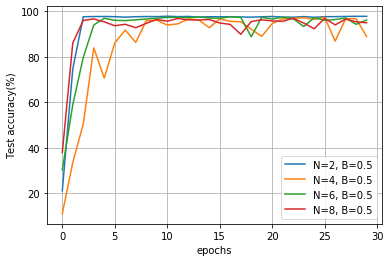

In [80]:
B_sel = 0

plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [122]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


# N_array = [3,4,5,6,7,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v3 = np.zeros((alloc_case,len(B_array),N_trials,N_epochs))
acc_test_arr_v3  = np.zeros((alloc_case,len(B_array),N_trials,N_epochs))

for N_idx in range(alloc_case):
    
#     N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N_idx==0:
            N = 2
            z_array = np.array([-0.81, 0.81])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
#             z_array = np.array([-0.82, -0.21, -0.08, 0.08, 0.21, 0.82])
        elif N_idx ==1:
            N = 2
            z_array = np.array([-0.22, 0.22])
        elif N_idx ==2:
            N = 2
            z_array = np.array([-0.81, 0.22])
        elif N_idx == 3:
            N = 8
            z_array = np.array([-0.9, -0.81, -0.22, 0, 0.22, 0.81, 0.9])
        else:
            N = 2
            z_array = np.array([-0.81, 0.22])

            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v3[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v3[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.1951 
Accuracy: 3126/10000 (31.26%)

Round   0, Average loss 2.195 Test accuracy 31.260
selected users: [0 1]

Test set: Average loss: 0.6087 
Accuracy: 9283/10000 (92.83%)

Round   1, Average loss 0.609 Test accuracy 92.830
selected users: [0 1]

Test set: Average loss: 0.1938 
Accuracy: 9735/10000 (97.35%)

Round   2, Average loss 0.194 Test accuracy 97.350
selected users: [0 1]

Test set: Average loss: 0.2140 
Accuracy: 9755/10000 (97.55%)

Round   3, Average loss 0.214 Test accuracy 97.550
selected users: [0 1]

Test set: Average loss: 0.2363 
Accuracy: 9763/10000 (97.63%)

Round   4, Average loss 0.236 Test accuracy 97.630
selected users: [0 1]

Test set: Average loss: 0.2427 
Accuracy: 9791/10000 (97.91%)

Round   5, Average loss 0.243 Test accuracy 97.910
selecte


Test set: Average loss: 0.3794 
Accuracy: 9052/10000 (90.52%)

Round  28, Average loss 0.379 Test accuracy 90.520
selected users: [0 1]

Test set: Average loss: 0.3946 
Accuracy: 8786/10000 (87.86%)

Round  29, Average loss 0.395 Test accuracy 87.860
2
z_array: [-0.81  0.22]
0.4838626198316927
0.468528808996694
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 1.2633 
Accuracy: 8008/10000 (80.08%)

Round   0, Average loss 1.263 Test accuracy 80.080
selected users: [0 1]

Test set: Average loss: 0.4987 
Accuracy: 9263/10000 (92.63%)

Round   1, Average loss 0.499 Test accuracy 92.630
selected users: [0 1]

Test set: Average loss: 0.2882 
Accuracy: 9512/10000 (95.12%)

Round   2, Average loss 0.288 Test accuracy 95.120
selected users: [0 1]

Test set: Average loss: 0.2779 
Accuracy: 9489/10000 (94.89%)

Round   3, Average loss 0.278 Test accuracy 94.890
selected users: [0 1]

Test set

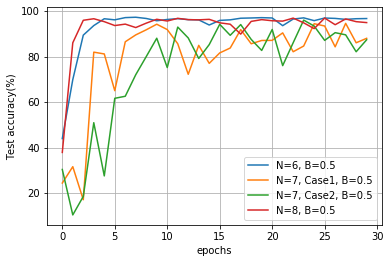

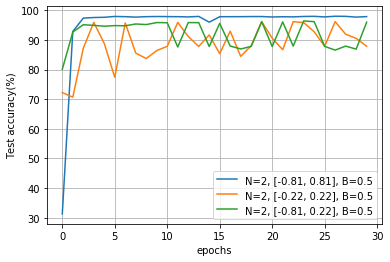

In [124]:
B_sel = 0

plt.plot(acc_test_arr_v2[0,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v2[1,B_sel,0,0:30],label='N=7, Case1, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v2[2,B_sel,0,0:30],label='N=7, Case2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v2[1,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v2[2,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))

plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

plt.plot(acc_test_arr_v3[0,B_sel,0,0:30],label='N=2, [-0.81, 0.81], B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v3[1,B_sel,0,0:30],label='N=2, [-0.22, 0.22], B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v3[2,B_sel,0,0:30],label='N=2, [-0.81, 0.22], B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v2[1,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v2[2,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))

plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

In [100]:

z_array = np.array([-0.84, -0.82, -0.22, -0.20, 0.18, 0.22, 0.82, 0.9])
z_array_sel = z_array
X_tilde_s0,a,b = BACC_Enc_Data_v3(encoding_input_array_np, len(z_array_sel), K, T, sigma, alpha_array, z_array_sel, _Noise_Alloc = Noise_Alloc)


@BACC_Enc: N,K,T, m_i= 8 2 3 30000 



30000


<Figure size 432x288 with 0 Axes>

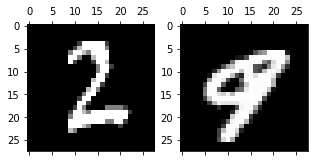

<Figure size 432x288 with 0 Axes>

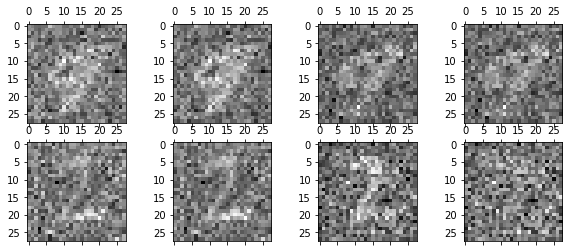

In [103]:
index_num = 0

Size_submatrices = 30000

index_sel = np.array(range(K))*Size_submatrices + index_num

input_images = encoding_input_array_np[index_sel,:]
input_labels = encoding_label_array_np[index_sel,:]


print(Size_submatrices)
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,K):
    ax = fig.add_subplot(1,6,i+1)
    pixels = input_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

np.set_printoptions(precision=3)

plt.gray()
fig = plt.figure( figsize=(10,4) )

encoded_images = X_tilde_s0[:,index_num,:]

for i in range(0,8):
    ax = fig.add_subplot(2,4,i+1)
    pixels = encoded_images[i,:].reshape((28, 28))
    ax.matshow(pixels)
plt.show()

In [105]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,5, 6,8]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        if N==2:
            z_array = np.array([-0.88, 0.88])
        elif N ==4:
            z_array = np.array([-0.88, -0.25, 0.25, 0.88])
        elif N ==5:
            z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
        elif N ==6:
            z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
        elif N ==7:
            z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
        else:
            z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma,_is_LCC=True))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=True) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=True)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

[ 9.511e-01  5.878e-01  6.123e-17 -5.878e-01 -9.511e-01]
[-0.22  0.22]


NameError: name 'PI' is not defined